In [1]:
from keras.layers import Input, Dense, Embedding, LSTM, Dropout, concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.utils.np_utils import to_categorical
import keras.backend as K
from functools import partial
import pandas as pd
import numpy as np
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
def normalize_y_pred(y_pred):
    return K.one_hot(K.argmax(y_pred), y_pred.shape[-1])

def class_true_positive(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true[:, class_label] + y_pred[:, class_label], 2), K.floatx())

def class_accuracy(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true[:, class_label], y_pred[:, class_label]),
                  K.floatx())

def class_precision(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.sum(class_true_positive(class_label, y_true, y_pred)) / (K.sum(y_pred[:, class_label]) + K.epsilon())


def class_recall(class_label, y_true, y_pred):
    return K.sum(class_true_positive(class_label, y_true, y_pred)) / (K.sum(y_true[:, class_label]) + K.epsilon())


def class_f_measure(class_label, y_true, y_pred):
    precision = class_precision(class_label, y_true, y_pred)
    recall = class_recall(class_label, y_true, y_pred)
    return (2 * precision * recall) / (precision + recall + K.epsilon())


def true_positive(y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true + y_pred, 2),
                  K.floatx())


def micro_precision(y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.sum(true_positive(y_true, y_pred)) / (K.sum(y_pred) + K.epsilon())


def micro_recall(y_true, y_pred):
    return K.sum(true_positive(y_true, y_pred)) / (K.sum(y_true) + K.epsilon())


def micro_f_measure(y_true, y_pred):
    precision = micro_precision(y_true, y_pred)
    recall = micro_recall(y_true, y_pred)
    return (2 * precision * recall) / (precision + recall + K.epsilon())


def average_accuracy(y_true, y_pred):
    class_count = y_pred.shape[-1]
    class_acc_list = [class_accuracy(i, y_true, y_pred) for i in range(class_count)]
    class_acc_matrix = K.concatenate(class_acc_list, axis=0)
    return K.mean(class_acc_matrix, axis=0)


def macro_precision(y_true, y_pred):
    class_count = y_pred.shape[-1]
    return K.sum([class_precision(i, y_true, y_pred) for i in range(class_count)]) / K.cast(class_count, K.floatx())


def macro_recall(y_true, y_pred):
    class_count = y_pred.shape[-1]
    return K.sum([class_recall(i, y_true, y_pred) for i in range(class_count)]) / K.cast(class_count, K.floatx())


def macro_f_measure(y_true, y_pred):
    precision = macro_precision(y_true, y_pred)
    recall = macro_recall(y_true, y_pred)
    return (2 * precision * recall) / (precision + recall + K.epsilon())

def weight_variable(shape):
    return K.truncated_normal(shape, stddev = 0.01)

In [3]:
#データの読み込み
use_data = pd.read_csv(filepath_or_buffer="Datas/pickup_data.csv", encoding="utf_8", sep=",")
print(len(use_data))
use_data.info()

20000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
screen_name    20000 non-null object
user_id        20000 non-null float64
tweet_id       20000 non-null float64
tweet          20000 non-null object
tweet2         20000 non-null object
postdate       20000 non-null object
cos_day        20000 non-null float64
sin_day        20000 non-null float64
tag            20000 non-null object
image_url      20000 non-null object
image          20000 non-null int64
retweet        20000 non-null float64
dtypes: float64(5), int64(1), object(6)
memory usage: 1.8+ MB


In [4]:
maxlen = 50
train = 0.7
validation = 0.1
max_words = 25000

#データをランダムにシャッフル
use_data_s = use_data.sample(frac=1, random_state=150)

# word indexを作成
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(use_data_s['tweet2'])
sequences = tokenizer.texts_to_sequences(use_data_s['tweet2'])

word_index = tokenizer.word_index
print("Found {} unique tokens.".format(len(word_index)))

data = pad_sequences(sequences, maxlen=maxlen)

# バイナリの行列に変換
categorical_labels = to_categorical(use_data_s['retweet'])
labels = np.asarray(categorical_labels)

print("Shape of data tensor:{}".format(data.shape))
print("Shape of label tensor:{}".format(labels.shape))

indices = [int(len(labels) * n) for n in [train, train + validation]]
x_train, x_val, x_test = np.split(data, indices)
y_train, y_val, y_test = np.split(labels, indices)

Found 20281 unique tokens.
Shape of data tensor:(20000, 50)
Shape of label tensor:(20000, 2)


In [5]:
#学習データ内の掲載データ数のカウント
count = 0
for i in y_val:
    if i[1] == 1.0:
        count+=1
print(count)

1012


In [6]:
p_input = Input(shape=(50, ), dtype='int32', name='input_postText')

em = Embedding(input_dim=max_words, output_dim=50, input_length=50)(p_input)
d_em = Dropout(0.5)(em)
lstm_out = LSTM(32, kernel_initializer=weight_variable)(d_em)
d_lstm_out = Dropout(0.5)(lstm_out)
output = Dense(2, activation='softmax', name = 'output')(d_lstm_out)

model = Model(inputs=p_input, outputs = output)
optimizer = Adam(lr=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',  metrics=['acc', macro_precision, macro_recall, macro_f_measure])
model.summary()
#plot_model(model, show_shapes=True, show_layer_names=True, to_file='model_image/model1.png')

early_stopping = EarlyStopping(patience=1, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_postText (InputLayer)  (None, 50)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 50)            1250000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                10624     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 2)                 66        
Total params: 1,260,690
Trainable params: 1,260,690
Non-trainable params: 0
_________________________________________________________________


In [7]:
history = model.fit(x_train, y_train,
                    epochs=50, 
                    batch_size=256,
                    validation_data=(x_val, y_val))#,
                    #callbacks=[early_stopping])

Train on 14000 samples, validate on 1999 samples
Epoch 1/50
14000/14000 [==============================] - 10s 682us/step - loss: 0.6929 - acc: 0.5359 - macro_precision: 0.5417 - macro_recall: 0.5373 - macro_f_measure: 0.5395 - val_loss: 0.6926 - val_acc: 0.5753 - val_macro_precision: 0.5815 - val_macro_recall: 0.5764 - val_macro_f_measure: 0.5789
Epoch 2/50
14000/14000 [==============================] - 6s 452us/step - loss: 0.6912 - acc: 0.5844 - macro_precision: 0.6078 - macro_recall: 0.5844 - macro_f_measure: 0.5957 - val_loss: 0.6894 - val_acc: 0.6368 - val_macro_precision: 0.6387 - val_macro_recall: 0.6370 - val_macro_f_measure: 0.6379
Epoch 3/50
14000/14000 [==============================] - 7s 492us/step - loss: 0.6808 - acc: 0.6384 - macro_precision: 0.6538 - macro_recall: 0.6392 - macro_f_measure: 0.6463 - val_loss: 0.6710 - val_acc: 0.6138 - val_macro_precision: 0.6397 - val_macro_recall: 0.6163 - val_macro_f_measure: 0.6277
Epoch 4/50
14000/14000 [==========================

14000/14000 [==============================] - 6s 398us/step - loss: 0.2876 - acc: 0.8831 - macro_precision: 0.8833 - macro_recall: 0.8834 - macro_f_measure: 0.8834 - val_loss: 0.5650 - val_acc: 0.7539 - val_macro_precision: 0.7537 - val_macro_recall: 0.7537 - val_macro_f_measure: 0.7537
Epoch 29/50
14000/14000 [==============================] - 6s 404us/step - loss: 0.2815 - acc: 0.8836 - macro_precision: 0.8837 - macro_recall: 0.8838 - macro_f_measure: 0.8837 - val_loss: 0.5695 - val_acc: 0.7504 - val_macro_precision: 0.7503 - val_macro_recall: 0.7503 - val_macro_f_measure: 0.7503
Epoch 30/50
14000/14000 [==============================] - 6s 418us/step - loss: 0.2783 - acc: 0.8869 - macro_precision: 0.8874 - macro_recall: 0.8867 - macro_f_measure: 0.8871 - val_loss: 0.5684 - val_acc: 0.7484 - val_macro_precision: 0.7487 - val_macro_recall: 0.7480 - val_macro_f_measure: 0.7483
Epoch 31/50
14000/14000 [==============================] - 6s 441us/step - loss: 0.2710 - acc: 0.8912 - macro

In [8]:
loss_and_metrics = model.evaluate(x_test, y_test)
print(loss_and_metrics)

4001/4001 [==============================] - 1s 286us/step
[0.6890417848852537, 0.7455636090977256, 0.7443871053419421, 0.7462203433977845, 0.7452411989783144]


In [10]:
classes = model.predict(x_test)
#np.savetxt('Datas/result/model1_dA_predict.csv', classes, delimiter = ',')

In [12]:
#model.save('Datas/models/model1_dA.h5')

In [ ]:
#シード値150 0.7700574856285929, 0.7703967081162668, 0.769495237278837, 0.7698049866774773

<Figure size 432x288 with 0 Axes>

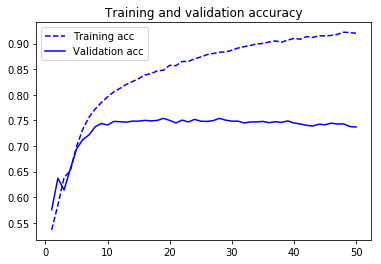

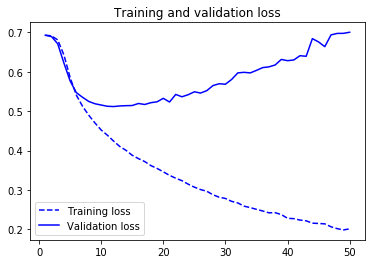

<Figure size 432x288 with 0 Axes>

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b--', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
#plt.savefig("RNN_tweet/Figs/N_method1/N_acc.png")

plt.figure()

plt.plot(epochs, loss, 'b--', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
#plt.savefig("RNN_tweet/Figs/N_method1/N_loss.png")

plt.figure()

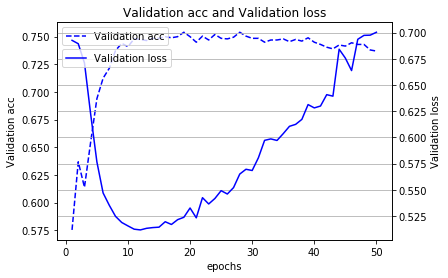

In [10]:
fig = plt.figure()
ax_acc = fig.add_subplot(111)
ax_acc.plot(epochs, val_acc, 'b--', label='Validation acc')
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=0.5, fontsize=10)

ax_loss = ax_acc.twinx()
ax_loss.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend(bbox_to_anchor=(0, 0.9), loc='upper left', borderaxespad=0.5, fontsize=10)
plt.title('Validation acc and Validation loss')
ax_acc.set_xlabel('epochs')
ax_acc.set_ylabel('Validation acc')
ax_loss.grid(True)
ax_loss.set_ylabel('Validation loss')
plt.show()

#plt.savefig("N_f_measure.png")